In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [6]:
%matplotlib inline

# Read all the  Calibration images
image_paths = glob.glob("./camera_cal/calibration*.jpg")

## Object Point and Image Point array creation for each image
objpoints = [] # Object Points Array 
imgpoints = [] # Image Points Array 
pass_img = []

#Identify 6*9 object points
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Read each image , find chessboard coreners and draw the chess board corners 
# Store paths of images in which coreners were found.
for img_path in image_paths:
    # Read Image from the path
    img = cv2.imread(img_path)
    # Convert image to gray scale.
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find Chess board coreners in the image
    ret , corners = cv2.findChessboardCorners(gray,(6,9),None)
    # If chess board coreners were found store the points in list
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp) 
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        pass_img.append(img_path)

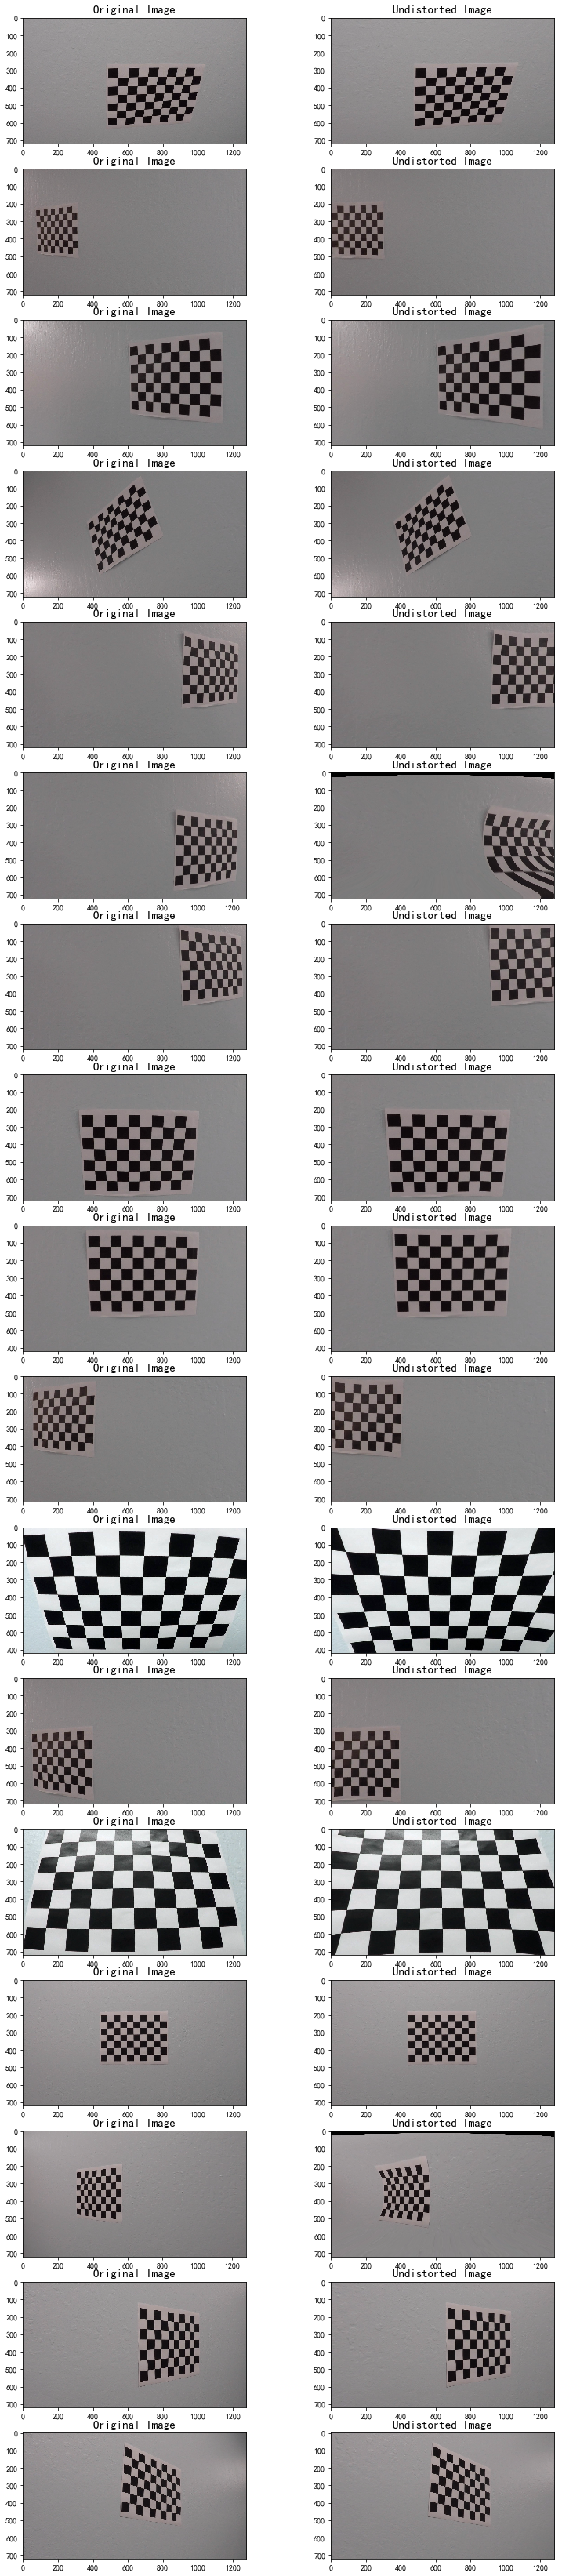

In [7]:
# Function to calibrate camera 
# Accepts image , object points and image points
# Return Undistored image
def cal_undistort(img, objpoints, imgpoints):
    # Convert image to gray scale    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Perform Camera Calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Undistore the images.
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Undistort all the Camera Calibration Images.
cnt =0
f, ax = plt.subplots(len(pass_img), 2,figsize=(10,50))
for img_path in pass_img:
    # Read in an image
    img = cv2.imread(img_path)
    # Undistor the image
    undistorted = cal_undistort(img, objpoints, imgpoints)
    # Show original and undistored images.
    ax[cnt,0].imshow(img)
    ax[cnt,0].set_title('Original Image', fontsize=15)
    ax[cnt,1].imshow(undistorted)
    ax[cnt,1].set_title('Undistorted Image', fontsize=15)
    cnt+=1
    mpimg.imsave('./output_images/undistorted_images/calibration'+str(cnt)+'.jpg',undistorted)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

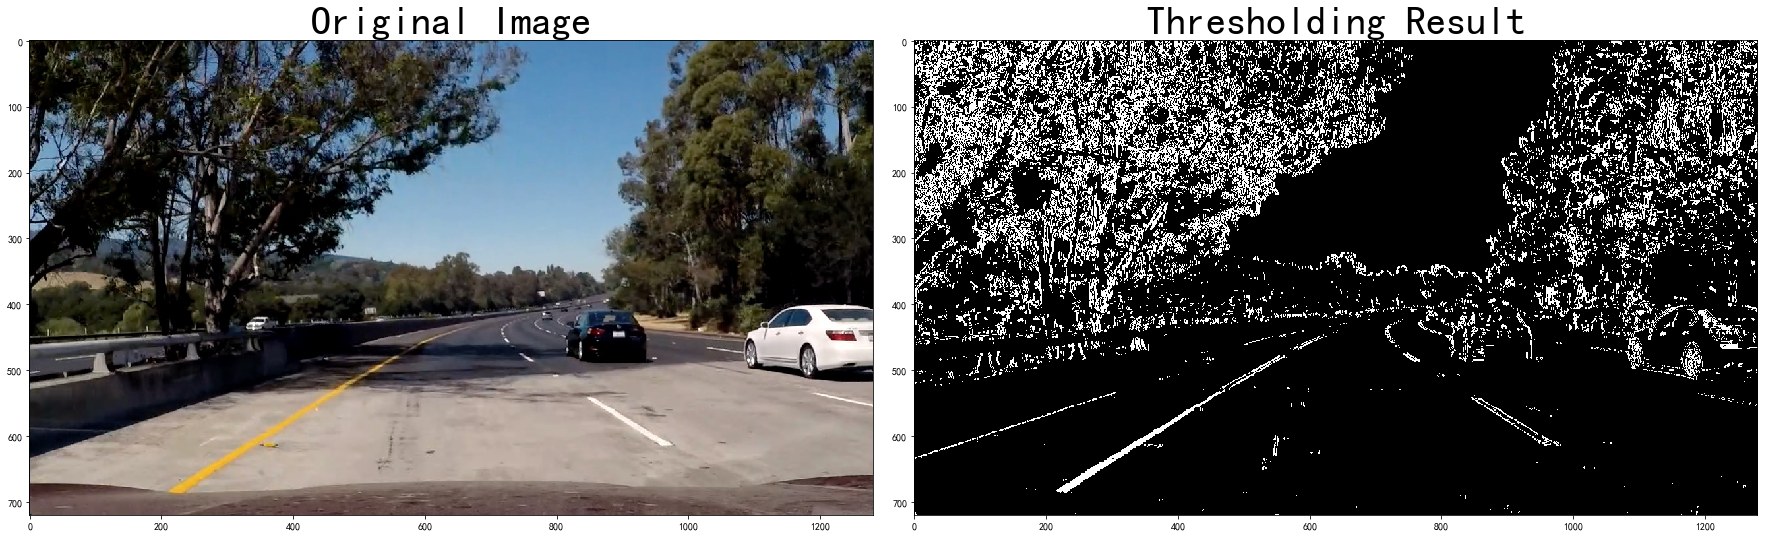

In [8]:
# Funtion to perform thresholding 
# Color image is formed by using combinded binary of s, h and sobelx 
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Convert to Gray Scale
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # S channel Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # H channel Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= sx_thresh[0]) & (h_channel <= sx_thresh[1])] = 1
    
    # Form a combinded image
    combinded_binary = np.zeros_like(sxbinary)
    combinded_binary[((h_binary==1)&(s_binary==1))|(sxbinary==1)]=1
    
    # Form a color binary by using combinded binary
    color_binary = np.dstack((combinded_binary,combinded_binary,combinded_binary))*255
    
    return color_binary

# Test Image
image = mpimg.imread("./test_images/test5.jpg")
result = threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,'gray')
ax2.set_title('Thresholding Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Store the Thresholded Image
mpimg.imsave('./output_images/threshold_images/Test5.jpg',result)


In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.count =0
    # Function to update the Lane Lines X , Y and Polynomial Coefficients
    def update_coordinates(self,x,y,fit):
        # Save X and Y values
        self.allx = x
        self.ally = y
        # Average Filter
        self.count +=1
        if self.count>20:
            self.count = 20
            # remove the oldest entry to out_buf if the length of out_buf is more than 'outbuf_len' 
            self.current_fit.pop(0)
            self.recent_xfitted.pop(0)
        # Add new values     
        self.current_fit.append(fit)
        self.recent_xfitted.append(x)
        # Average the values
        self.bestx = np.average(self.recent_xfitted,axis=0)    
        self.best_fit = np.average(self.current_fit,axis=0)    
        
right_lane_obj = Line()
left_lane_obj = Line()

In [ ]:
# Function to perform Perspective Transform 
# Accepts Image to be transformed and Source Points
# Returns warped image and Inverse M for reversing the transform in future
def perspective_transform(img,src):
    # Store the image size in an array
    img_size = (img.shape[1],img.shape[0])
    # Identify the destination points
    dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])
    # Use CV2 funtion to perform perspective transform 
    M = cv2.getPerspectiveTransform(src, dst)
    # Use CV2 funtion to Inverse Perspective transform for future use
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Use CV2 funtion and transform the image 
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    # Return Warped and Inverse Perspective Transform Matrix for future use.
    return warped, Minv

In [ ]:
# Function to find lanes
# Accepts binary warped image
# Returns Image with overlayed lanes , polynomial coefficients, x and y values of left, right lanes

def find_lanes(binary_warped,left_fit,right_fit):    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Load the best fit values 
    left_fit = left_lane_obj.best_fit
    right_fit = right_lane_obj.best_fit
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if((left_fit != None) and (right_fit != None)):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
         
    else:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Highlight Left Lane in Red and Right in Blue    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Create Evenly Spaced Y values and extract x values for each x 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Limit the X to be with in the image boundaries
    left_fitx[(left_fitx>1280)]=1279
    right_fitx[(right_fitx>1280)]=1279
    left_fitx[left_fitx<0]=0
    right_fitx[right_fitx<0]=0
    
    # Highlight the Left and Right Lanes in Green 
    out_img[np.int32(ploty),np.int32(left_fitx)] = [255,255,0]
    out_img[np.int32(ploty),np.int32(right_fitx)] = [255,255,0]
    
    # Return Image with overlayed lanes , polynomial coefficients, x and y values of left, right lanes 
    return out_img,np.dstack((left_fit,right_fit)),np.dstack((ploty,left_fitx,right_fitx))

In [ ]:
# Function to draw lanes and fill the space between lanes in green
# Input: Warped Image , Original Undistored image , Left & Right X , Inverse Perspective Matrix
# Returns: Image with overlayed lanes and area between lanes filled in green
def draw_lines(warped,undist,ploty,left_fitx,right_fitx,Minv):
    margin = 15
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw the lane onto the warped blank image
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Highlight Left Lane in Red and Right in Blue 
    cv2.fillPoly(color_warp, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(color_warp, np.int_([right_line_pts]), (0,0,255))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return(result)

In [ ]:
# Function to calculate Radius of Curvature at the vehicle edge
# Input: Y Points , Left and Right Lane X values
# Output: Left and Right Lange Curvature
def cal_radius_curvature(ploty,leftx,rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Evaluate the radius at the edge of the vehicle 
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad,right_curverad    

In [ ]:
# Source Points for Perspecitive Transformation
points = np.float32([[(200, 720), (570, 470), (720, 470), (1130, 720)]])
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

# Read all the  Test image path
test_image_paths = glob.glob("./test_images/*.jpg")

f, ax = plt.subplots(len(test_image_paths), 2,figsize=(20,60))
left_fit =[]
right_fit=[]

cnt =0
for imagep in test_image_paths:
    # Empty the Polynomials as these images are different
    left_fit =[]
    right_fit=[]
    # Read the Image from the path
    image = mpimg.imread(imagep)
    # Undistort the image
    undistorted = cal_undistort(image, objpoints, imgpoints)
    mpimg.imsave('./output_images/undistorted_images/test'+str(cnt)+'.jpg',undistorted)
    # Peform Thresholding
    thr_image = threshold(undistorted)
    mpimg.imsave('./output_images/threshold_images/test'+str(cnt)+'.jpg',thr_image)
    # Perspecitive Transform the Images
    warped,persp_invM = perspective_transform(thr_image,points)
    mpimg.imsave('./output_images/perspective_images/test'+str(cnt)+'.jpg',warped)
    # Convert to gray scale
    warped_gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
    # Find Lane Lines in the images        
    out_img,poly_fit,coord_fit = find_lanes(warped_gray,left_fit,right_fit)
    
    # Draw the lane lines
    left_fit = poly_fit[0,:,0]
    right_fit = poly_fit[0,:,1]
    
    out_img = draw_lines(warped_gray,undistorted,coord_fit[0,:,0],coord_fit[0,:,1],coord_fit[0,:,2],persp_invM)
    
    #######  Calculate the Radius of curvature #####
    left_rad_cuv,right_rad_cuv = cal_radius_curvature(coord_fit[0,:,0],coord_fit[0,:,1],coord_fit[0,:,2])
    # Average the Radius of curvature over 60 samples
    radius = ((left_rad_cuv+right_rad_cuv)/2)
    # Print the radius of curvature    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(out_img,'Radius of Curvature = '+str(radius)+'(m)',(100,30), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    # Calculte the offest
    offset = ((coord_fit[0,:,1][(image.shape[0]-1)]+coord_fit[0,:,2][(image.shape[0]-1)]-image.shape[1])*(3.7/1400))
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Print the offset
    cv2.putText(out_img,'Vehicle is '+str(offset)+'(m) left of center',(100,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    mpimg.imsave('./output_images/output/test'+str(cnt)+'.jpg',out_img)
    # Plot the result
    f.tight_layout()
    
    ax[cnt,0].imshow(image)
    ax[cnt,0].set_title('Original Image', fontsize=20)
    
    ax[cnt,1].imshow(out_img)
    ax[cnt,1].set_title('Overlayed Image', fontsize=15)
    cnt+=1
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Pipeline to process the images
# Input: Raw Image from Video
# Return: Processed Image with overlayed Lane Lines
def process_image(image):
    # Clear Pervious Image Curve values and Radius of curvature.
    left_fit =[]
    right_fit =[]
    radius = []
    rad_count =0
    
    #### PipeLine Start #####
    # Undistort the Image
    undistorted = cal_undistort(image, objpoints, imgpoints)
    # Perform Thresholding
    image_gray = threshold(undistorted)
    # Perspective Transform the image
    warped, persp_invM = perspective_transform(image_gray,points)
    # Convert to Gray scale 
    warped_gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
    # Find Lane Lines 
    out_img,poly_fit,coord_fit = find_lanes(warped_gray,left_fit,right_fit)
    # Store Left and Right Polynomial
    left_fit = poly_fit[0,:,0]
    right_fit = poly_fit[0,:,1]
    # Update the Left and Right Object Parameters
    left_lane_obj.update_coordinates(coord_fit[0,:,1],coord_fit[0,:,0],(left_fit))
    right_lane_obj.update_coordinates(coord_fit[0,:,2],coord_fit[0,:,0],(right_fit))
    # Draw the Lane Lines on the image
    out_img = draw_lines(warped_gray,undistorted,coord_fit[0,:,0],coord_fit[0,:,1],coord_fit[0,:,2],
                         persp_invM)
    
    #######  Calculate the Radius of curvature #####
    left_lane_obj.radius_of_curvature,right_lane_obj.radius_of_curvature = cal_radius_curvature(coord_fit[0,:,0],left_lane_obj.bestx,right_lane_obj.bestx)
    # Average the Radius of curvature over 60 samples
    radius.append((left_lane_obj.radius_of_curvature+right_lane_obj.radius_of_curvature)/2)
    rad_count+=1
    if(rad_count>60):
        rad_count=60
        radius.pop(0)
    # Print the radius of curvature    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(out_img,'Radius of Curvature = '+str(np.average(radius))+'(m)',(100,30), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    # Calculte the offest
    offset = ((coord_fit[0,:,1][(image.shape[0]-1)]+coord_fit[0,:,2][(image.shape[0]-1)]-image.shape[1])*(3.7/1400))
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Print the offset
    cv2.putText(out_img,'Vehicle is '+str(offset)+'(m) left of center',(100,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    # Return the overlayed image
    return out_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import * 

cap = VideoFileClip('project_video.mp4')
modified_clip = cap.fl_image( process_image )
%time modified_clip.write_videofile("output_videos/project_video.mp4")

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/project_video.mp4"))